# Demonstration notebook: Simulating message transmission across social network via ERGM and SEIR model with MCMC

The key idea of this project is to simulate information spread behaviours and user networks on internet social media platform with (disease) transmission model and graph model.

In [1]:
library(epinet)
library(network) #plot
library(here)


epinet: version 2.1.11, created on 2023-11-29



‘network’ 1.18.2 (2023-12-04), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


here() starts at /home/arimo/Desktop/Studily/Socialnetwork-SEIR



## Finding prior weights with visualization

According to the social media data, there are about half of the users who reposted the message do not have a direct follow relationship with their parent node. Those users are considered isolated from other users in this social network. Meanwhile, a few users have many followers, resulting in many connections. The rest of the reposts are in a chained manner, that is, the message is passed from one to another. We can use these infomation to have a reasonable guess to the network parameter $\eta$. The shown network satisfies these features.

In [2]:
# Building network with node info
mynodcov <- read.csv(here("data/nodcov_filled.csv"))
mydyadCov = BuildX(mynodcov, unaryCol = c(1,2,3,4,5,6,7,8), 
                   unaryFunc = c("match","match","match","absdiff","absdiff","absdiff","absdiff","match"))

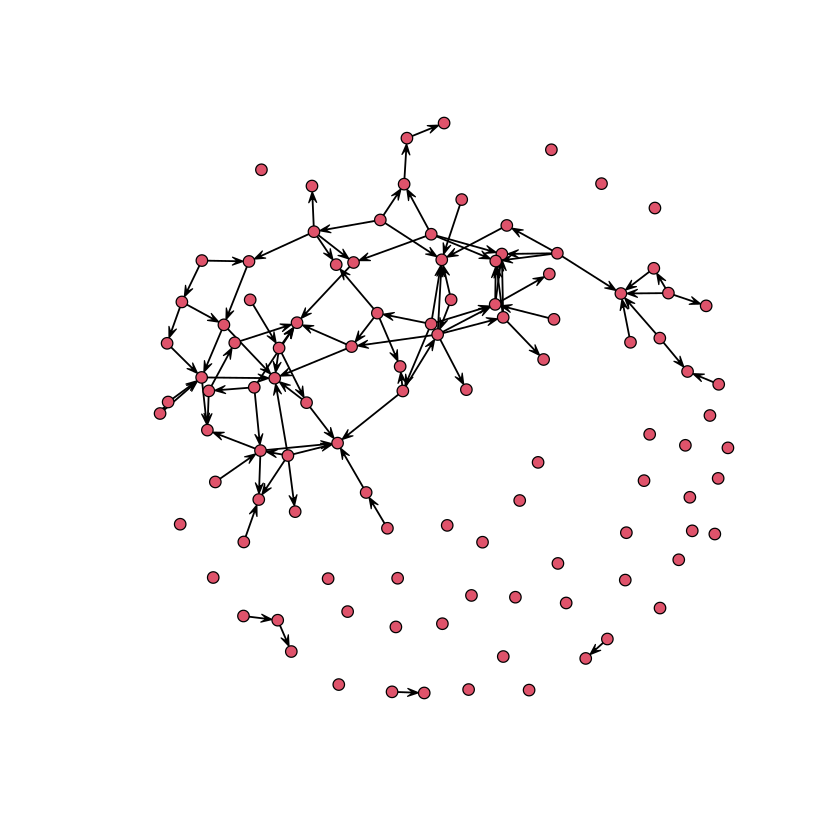

In [4]:
#   NodeID, sex, location, post, follower, following, level, vip, checkmark
eta <- c(0,-0.02,    -0.5,-0.001, -0.0003,    -0.001,-0.005,-0.002,  -0.001)
mynet <- SimulateDyadicLinearERGM(N = nrow(mynodcov), dyadiccovmat = mydyadCov, eta = eta)
plot(as.network(mynet))

## MCMC simulation with transmission data

In [5]:
Times <- read.csv(here("data/Re_est_Time.csv"))
Times <- data.matrix(Times)
Times[,5] <- Times[,5]+1 # Fixing Rtime to avoid Itime and Rtime being equal i.e. set minimal I period as 1

The priors are decided (selected) with groups of experiments

In [6]:
priors <- priorcontrol(etaprior = c(0, 0, 0, 0, 0, 0, 0, 0),
                       bprior = c(0, 4), tiprior = c(0.25, 0.75), teprior = c(0.25, 1),
                       keprior = c(8, 20), kiprior = c(15, 25), priordists = "uniform")

Considering the content of this post (cat rescue information on a very specific location), the selected three attributes are location matching `location.match`, the absolute difference of post `post_count.diff`, and follower number `follower_count.diff`

The underlying assumptions are: the more followers a user has, the more likely that other users see the information from them; the more post a user have posted implies that this user browse the social media more often thus is also more likely to spread the information.

The following code performs MCMC simulation and takes time to run (~20 sec for 10000 iters)

In [ ]:
mcmcinput <- MCMCcontrol(nsamp = 200000, thinning = 100, # for final generation, set nsamp = 10,000,000 iterations
                         extrathinning = 10, burnin = 10000, seed = 1,
                         etapropsd = c(rep(0.05, times = 3), 0.005))

result <- epinet(~ `location.match` + `follower_count.diff` + `post_count.diff`,
              epidata = Times, dyadiccovmat = mydyadCov,
              mcmcinput = mcmcinput, priors = priors)

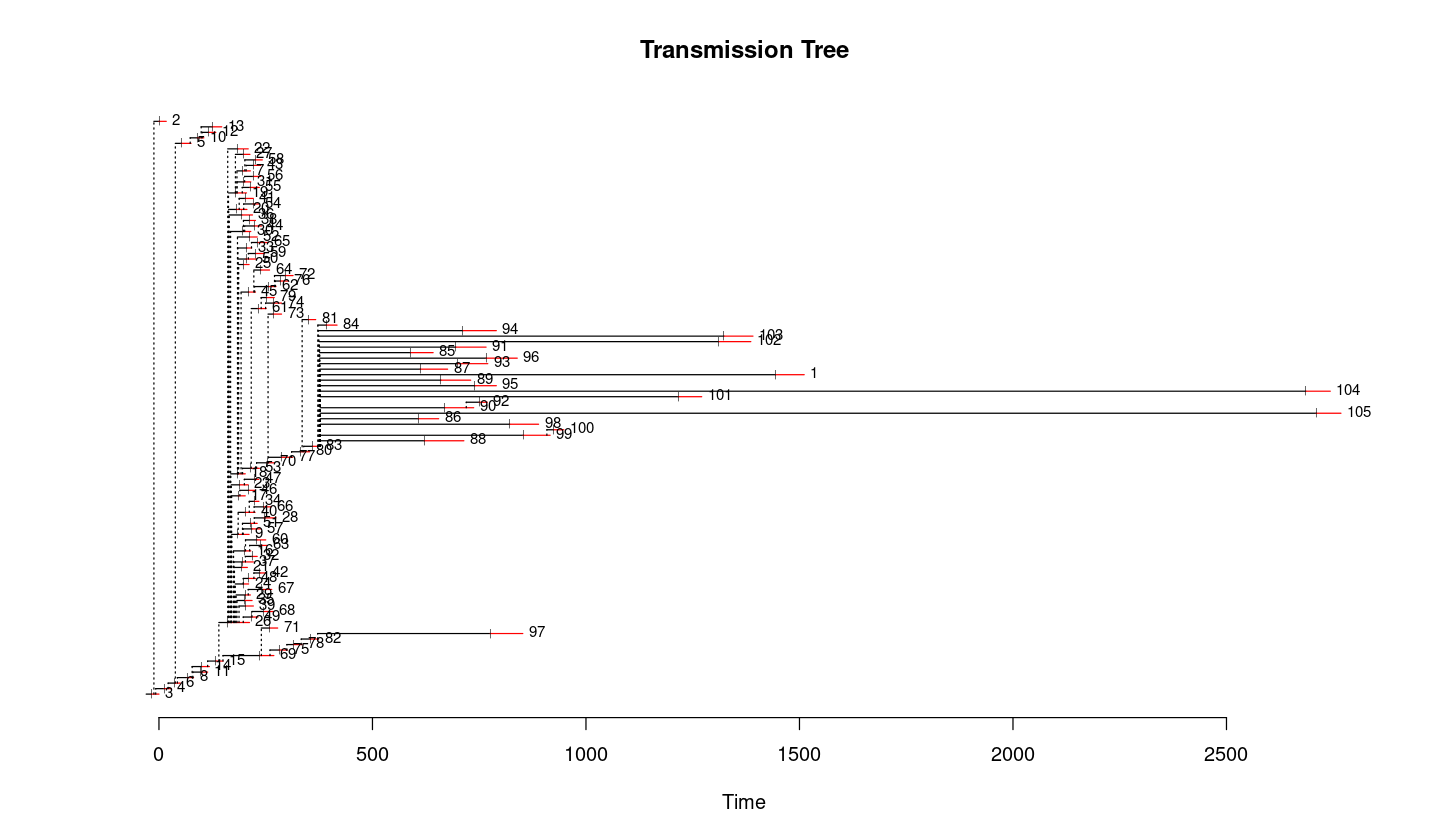

In [43]:
options(repr.plot.width = 12, repr.plot.height = 7)
plot(result, index = 20)

## Convergence test
The Geweke diagnostic (a convergence diagnostic for Markov chains) can be performed with:

In [18]:
library("coda")

In [22]:
geweke.diag(as.mcmc(result$beta))


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

 var1 
1.193 


In [ ]:
x = 1:length(vec), y = vec

It's also possible to plot trace plots. In this example, the number of iteration very small so it's hard to conclude convergence.

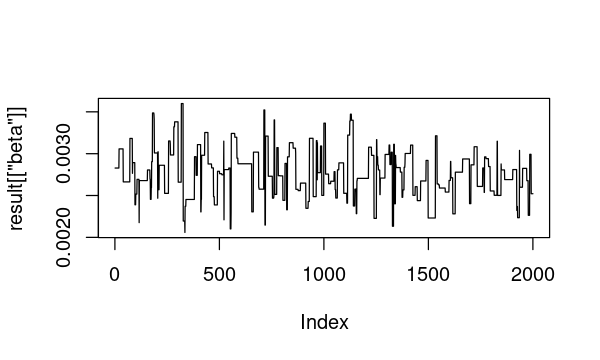

In [36]:
options(repr.plot.width = 5, repr.plot.height = 3)
plot(result[["beta"]],type = "l")

For the eta parameter that has 3 components, it's possible to use
```
library("bayesplot")
mcmc_trace(result[["eta"]])
```

## Posteriors
The posterior distribution can be checked with histograms:

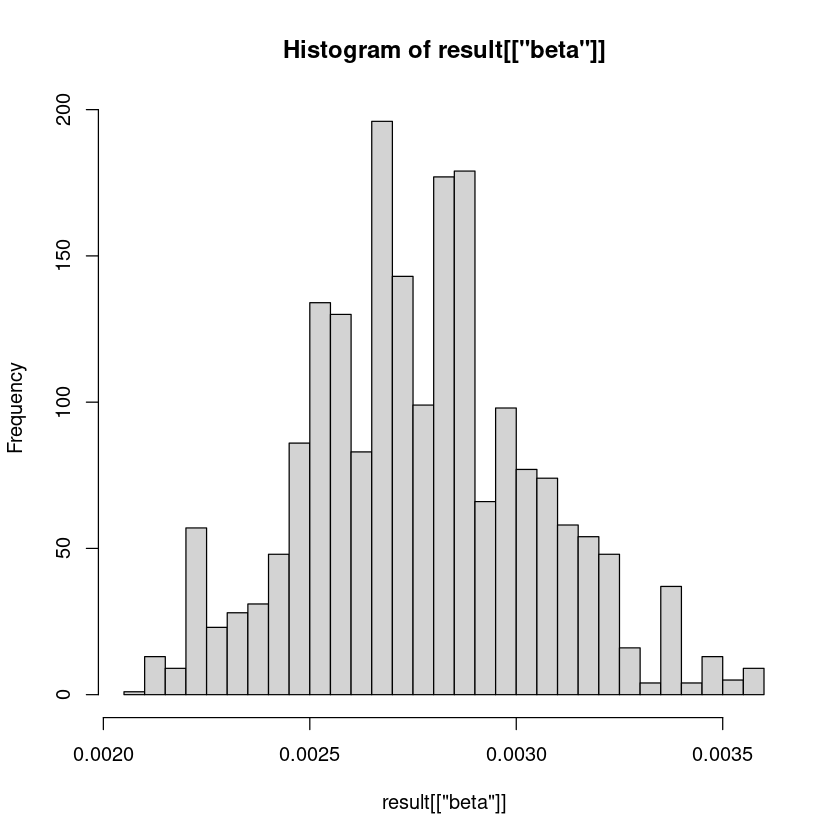

In [26]:
hist(result[["beta"]],breaks="FD")